As seen in the previous notebook, the dataset has two types of classes which are concentric in nature. However, as seen in the notebook, the decision boundry is a straight line. Hence, regardless of how many epochs the NN is trained, the model is going to have an accuracy of ~50%. This is because without any non-linearity in the input and the hidden layers, the model is only a combination of multiple linear models (y1 = m1x1+c1, y2 = m2x2+c2,..... and so on) and it can be proven that a combination of multiple linear equations is itself a linear equation. In order to fix this problem and allow the NN to learn a decision boundary that has a non-linear shape, we should introduce non-linearity in the layers of the NN.<br><br>
On top of that, there are other ways to make a NN model perform better than before by making the following changes. <br>
- Increase the number of hidden layers and the width of each NN layer.
- Change the optimization/loss function.
- Change the activation function.
- Alter the learning rate or use a learning rate scheduler.
- Train shorter/longer if necessary.
- Get more training data or augment data if possible.

#### Create classification data.

In [1]:
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

# create dots in a 2D space where the dots are within two concentric circles
X,y = make_circles(n_samples = n_samples,
                   noise=0.03,
                   random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[0:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [5]:
y[0:5]

array([1, 1, 1, 1, 0], dtype=int64)

Make dataframe of this data for proper visualization.

In [6]:
import pandas as pd

circles_df = pd.DataFrame({"X1":X[:,0],
                           "X2" : X[:,1],
                           "label" : y})
circles_df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


#### Visualize the data on 2D.

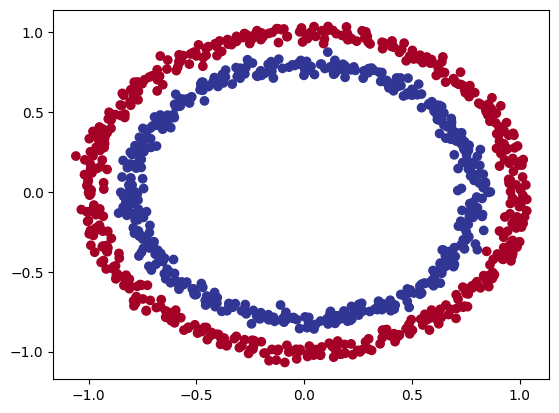

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x= X[:,0],
            y = X[:,1],
            c = y,
            cmap=plt.cm.rainbow)

Turns out the data set that we generated contained dots of two types, that were separated by a hollow space between them.

#### Check input and output shapes.

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

#### Convert numpy data into tensors.

In [9]:
import torch
torch.__version__

'2.0.0+cu118'

In [10]:
X_tensor = torch.from_numpy(X).type(torch.float32)
y_tensor = torch.from_numpy(y).type(torch.float32)

In [11]:
X_tensor[0:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [12]:
y_tensor[0:5]

tensor([1., 1., 1., 1., 0.])

#### Train-Test split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)


#### Improve NN training
Use deeper, wider, and non-linear layers.

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class Custom_Classifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_features=2, out_features=10) # 2 features of train data
        self.relu1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(in_features=10, out_features=10) # 5 nodes in the previous layer
        self.relu2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(in_features=10,out_features=1)
        # using BCEWithLogitLoss, hence explicit sigmoid activation not needed
        # self.sigmoid = torch.nn.Sigmoid()

    # slower version - cannot leverage speed-up behind the scene
    # def forward(self, x: torch.Tensor) -> torch.Tensor:
    #     """
    #     computes the forward pass of the torch.nn subclass instance
    #     """
    #     x = self.linear1(x)
    #     x = self.relu1(x)
    #     x = self.linear2(x)
    #     x = self.relu2(x)
    #     x = self.linear3(x)
    #     return x

    # speed-up version
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        computes the forward pass of the torch.nn subclass instance
        """
        return self.linear3(self.relu2(self.linear2(self.relu1(self.linear1(x)))))

Instantiate the model.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = Custom_Classifier().to(device=device)
classifier

Custom_Classifier(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

#### Make predictions before training

In [16]:
X_test[0:5]

tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438]])

In [17]:
classifier.eval()
with torch.inference_mode():
    predictions = classifier(X_test.to(device))

predictions[0:5]

tensor([[0.0167],
        [0.0207],
        [0.0126],
        [0.0171],
        [0.0420]], device='cuda:0')

#### Define Loss function.

In [18]:
# binary cross-entropy loss with logits
# avoiding explicit definition of sigmoid layer + BCE Loss for numerical optimization
loss_func = torch.nn.BCEWithLogitsLoss()


#### Improve NN training
In order to make our non-linear NN learn, we have two ways of training - either train with a large learning rate if the number of epochs is small or train with a small learning rate but for a large number of epochs. Lets see both below.

Setting 1: Large LR, small number of epochs.
The previous notebook used a learning rate of 0.01. Lets increase the LR by 10 folds.

In [19]:
# Using SGD/Adam optimizer
optimizer = torch.optim.SGD(params=classifier.parameters(), lr = 0.1)
# optimizer = torch.optim.Adam(params=classifier.parameters(), lr = 0.00001)
epochs = 100

In [20]:
#### Model Training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# ensure that you move the data to device in the same cell as the training loop
# this allows for model re-trianing without device error

X_train = X_train.to(device = device)
y_train = torch.unsqueeze(y_train, dim=1) # convert to same dimension as the network output
y_train = y_train.to(device=device)
X_test = X_test.to(device = device)
y_test = y_test.to(device=device)
y_test = torch.unsqueeze(y_test, dim = 1) # convert to same dimension as the network output

epoch_ctr = []
training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

for epoch in range(0, epochs):

    ### training mode
    classifier.train()

    # raw probabilities of each class
    train_prediction_logits = classifier(X_train)#.squeeze() squeezing not necessary if in same shape
    train_prediction_probs = torch.sigmoid(train_prediction_logits)
    # rounded to 0 or 1
    train_predictions = torch.round(train_prediction_probs)

    
    
    # uncomment for prototyping
    assert train_prediction_logits.shape == y_train.shape
    training_loss = loss_func(train_prediction_logits, y_train) # note: prediction is in logit, y_train not in logit
    # calculate accuracy without tracking gradients
    with torch.inference_mode():
        training_acc= (torch.eq(torch.squeeze(train_predictions), torch.squeeze(y_train)).sum().item()/len(y_train)) * 100.
    
    optimizer.zero_grad()

    # backpropagation: calculate the gradients using backpropagation for the entire dataset at once
    # hence, this is not Stochastic Gradient Descent, but rather Gradient Descent
    training_loss.backward()

    optimizer.step()

    ### evaluation mode
    classifier.eval()
    
    # pass X through model during eval time in inference mode to disable gradient tracking
    with torch.inference_mode():        

        test_prediction_logits = classifier(X_test)#.squeeze() squeezing not necessary if in same shape
        test_prediction_probs = torch.sigmoid(test_prediction_logits)
        test_predictions = torch.round(test_prediction_probs)
        
        # uncomment for prototyping
        assert test_prediction_logits.shape == y_test.shape
        test_loss = loss_func(test_prediction_logits, y_test)
        test_acc = (torch.eq(torch.squeeze(test_predictions), torch.squeeze(y_test)).sum().item()/len(y_test)) * 100.

        # store the training and test loss for the plot
        epoch_ctr.append(epoch)
        training_loss_list.append(training_loss.to("cpu").item())
        test_loss_list.append(test_loss.to("cpu").item())
        training_acc_list.append(training_acc)
        test_acc_list.append(test_acc)

    if epoch % (epochs/10) == 0:    
        print("\nEPOCH ", epoch, " | Training loss: ",round(training_loss.detach().item(),3)," | Test loss: ", round(test_loss.item(),3),\
        " | Training acc: ",round(training_acc,3),"% | Test acc: ", round(test_acc,3), "%")


EPOCH  0  | Training loss:  0.693  | Test loss:  0.693  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  10  | Training loss:  0.692  | Test loss:  0.693  | Training acc:  50.5 % | Test acc:  50.0 %

EPOCH  20  | Training loss:  0.692  | Test loss:  0.692  | Training acc:  59.125 % | Test acc:  56.5 %

EPOCH  30  | Training loss:  0.692  | Test loss:  0.692  | Training acc:  70.25 % | Test acc:  68.0 %

EPOCH  40  | Training loss:  0.692  | Test loss:  0.692  | Training acc:  68.375 % | Test acc:  71.0 %

EPOCH  50  | Training loss:  0.692  | Test loss:  0.692  | Training acc:  58.25 % | Test acc:  58.0 %

EPOCH  60  | Training loss:  0.692  | Test loss:  0.692  | Training acc:  54.0 % | Test acc:  54.5 %

EPOCH  70  | Training loss:  0.692  | Test loss:  0.691  | Training acc:  53.125 % | Test acc:  53.0 %

EPOCH  80  | Training loss:  0.691  | Test loss:  0.691  | Training acc:  52.625 % | Test acc:  53.0 %

EPOCH  90  | Training loss:  0.691  | Test loss:  0.691  | Training acc:

Visualize the loss and accuracy.

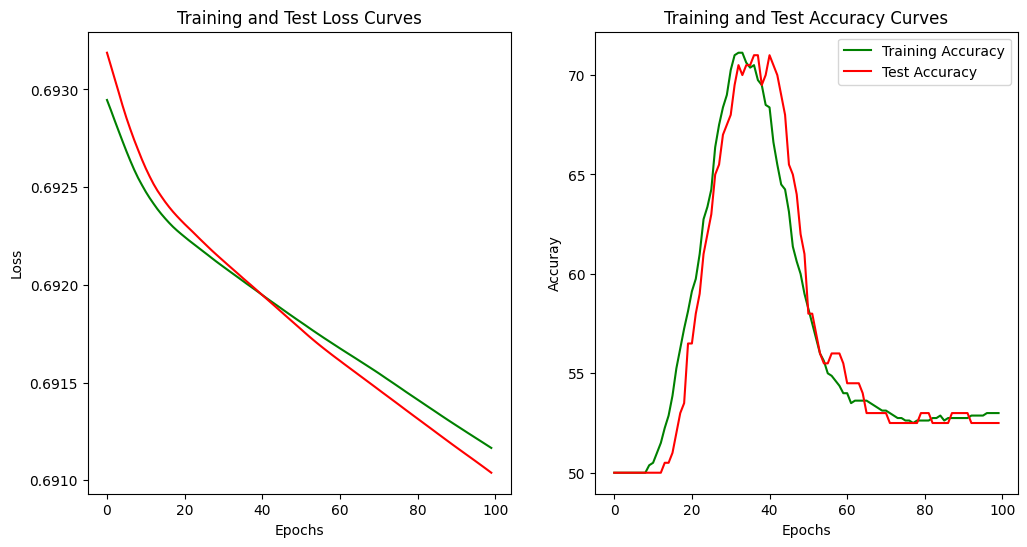

In [21]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epoch_ctr, training_acc_list, "g", label = "Training Accuracy")
plt.plot(epoch_ctr, test_acc_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen in the graph, using a large LR helped the model to learn and toward the end of the epochs, the models test accuracy flattened. This could be because of the large LR.

Visualize the predictions for setting 1.

In [22]:
# download helper functions
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists in the directory. Skipping the download.")
else:
    print("Downloading helper_functions.py")
    raw_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    request = requests.get(raw_url)

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists in the directory. Skipping the download.


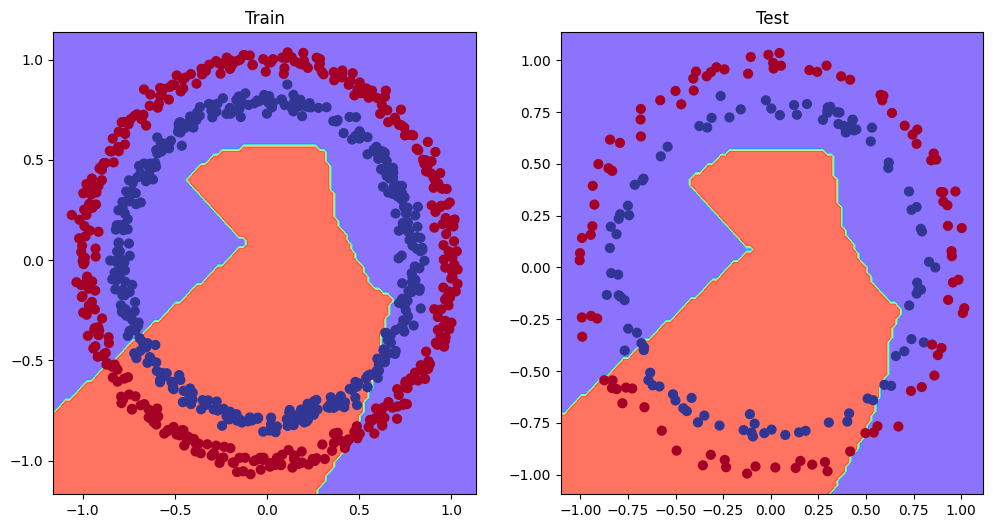

In [23]:
plt.figure(figsize=(12,6))
# 1 row in the plot, 2 columns in the plot, anything below in this slot 1
plt.subplot(1,2,1) 
plt.title("Train")
plot_decision_boundary(classifier, X_train, y_train)
# 1 row in the plot, 2 columns in the plot, anything below in this slot 2
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(classifier, X_test, y_test)

As seen above, introducing non-linearity in the model allowed us to get a non-linear decision boundary and the model was able to perform better than a random guess at 50% accuracy. However, note that since the lr is large, we would not be able to get the best accuracy possible with this training data since the gradient update would (almost) never reach the true function minimum in the contour of the optimization function. Hence, a better approach would be to use a small lr but a large number of epochs.

Setting 2: Small LR, large number of epochs.


In [24]:
# use manual seed to ensure that we start with the same weights and biases as the model in setting 1.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

classifier = Custom_Classifier().to(device=device)
classifier

Custom_Classifier(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# Using SGD/Adam optimizer
optimizer = torch.optim.SGD(params=classifier.parameters(), lr = 0.001)
# optimizer = torch.optim.Adam(params=classifier.parameters(), lr = 0.0001)
epochs = 100000

In [26]:
#### Model Training

# ensure that you move the data to device in the same cell as the training loop
# this allows for model re-trianing without device error
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

X_train = X_train.to(device = device)
y_train = torch.unsqueeze(y_train, dim=1) # convert to same dimension as the network output
y_train = y_train.to(device=device)
X_test = X_test.to(device = device)
y_test = y_test.to(device=device)
y_test = torch.unsqueeze(y_test, dim = 1) # convert to same dimension as the network output


# notice the increase in the number of epochs since the lr is very small
epoch_ctr = []
training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

for epoch in range(0, epochs):

    ### training mode
    classifier.train()

    # raw probabilities of each class
    train_prediction_logits = classifier(X_train)#.squeeze() squeezing not necessary if in same shape
    train_prediction_probs = torch.sigmoid(train_prediction_logits)
    # rounded to 0 or 1
    train_predictions = torch.round(train_prediction_probs)

    
    
    # uncomment for prototyping
    assert train_prediction_logits.shape == y_train.shape
    training_loss = loss_func(train_prediction_logits, y_train) # note: prediction is in logit, y_train not in logit
    # calculate accuracy without tracking gradients
    with torch.inference_mode():
        training_acc= (torch.eq(torch.squeeze(train_predictions), torch.squeeze(y_train)).sum().item()/len(y_train)) * 100.
    
    optimizer.zero_grad()
    
    # backpropagation: calculate the gradients using backpropagation for the entire dataset at once
    # hence, this is not Stochastic Gradient Descent, but rather Gradient Descent
    training_loss.backward()

    optimizer.step()

    ### evaluation mode
    classifier.eval()
    
    # pass X through model during eval time in inference mode to disable gradient tracking
    with torch.inference_mode():        

        test_prediction_logits = classifier(X_test)#.squeeze() squeezing not necessary if in same shape
        test_prediction_probs = torch.sigmoid(test_prediction_logits)
        test_predictions = torch.round(test_prediction_probs)
        
        # uncomment for prototyping
        assert test_prediction_logits.shape == y_test.shape
        test_loss = loss_func(test_prediction_logits, y_test)
        test_acc = (torch.eq(torch.squeeze(test_predictions), torch.squeeze(y_test)).sum().item()/len(y_test)) * 100.

        # store the training and test loss for the plot
        epoch_ctr.append(epoch)
        training_loss_list.append(training_loss.to("cpu").item())
        test_loss_list.append(test_loss.to("cpu").item())
        training_acc_list.append(training_acc)
        test_acc_list.append(test_acc)

    if epoch % (epochs/10) == 0:    
        print("\nEPOCH ", epoch, " | Training loss: ",round(training_loss.detach().item(),3)," | Test loss: ", round(test_loss.item(),3),\
        " | Training acc: ",round(training_acc,3),"% | Test acc: ", round(test_acc,3), "%")


EPOCH  0  | Training loss:  0.693  | Test loss:  0.693  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  10000  | Training loss:  0.691  | Test loss:  0.691  | Training acc:  53.0 % | Test acc:  52.5 %

EPOCH  20000  | Training loss:  0.69  | Test loss:  0.689  | Training acc:  53.375 % | Test acc:  55.0 %

EPOCH  30000  | Training loss:  0.688  | Test loss:  0.687  | Training acc:  53.0 % | Test acc:  56.0 %

EPOCH  40000  | Training loss:  0.685  | Test loss:  0.684  | Training acc:  52.75 % | Test acc:  56.5 %

EPOCH  50000  | Training loss:  0.681  | Test loss:  0.679  | Training acc:  52.75 % | Test acc:  56.5 %

EPOCH  60000  | Training loss:  0.675  | Test loss:  0.673  | Training acc:  54.5 % | Test acc:  56.0 %

EPOCH  70000  | Training loss:  0.666  | Test loss:  0.663  | Training acc:  58.375 % | Test acc:  59.0 %

EPOCH  80000  | Training loss:  0.651  | Test loss:  0.648  | Training acc:  64.125 % | Test acc:  67.5 %

EPOCH  90000  | Training loss:  0.623  | Test loss:

Visualize the loss and accuracy.

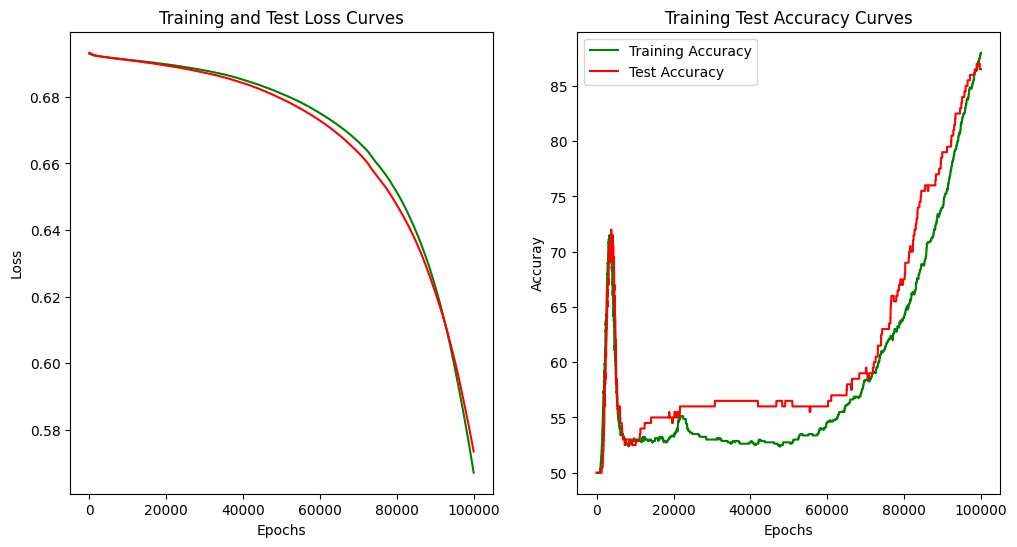

In [27]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epoch_ctr, training_acc_list, "g", label = "Training Accuracy")
plt.plot(epoch_ctr, test_acc_list, "r", label = "Test Accuracy")
plt.title("Training Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

#### Visualize the predictions.

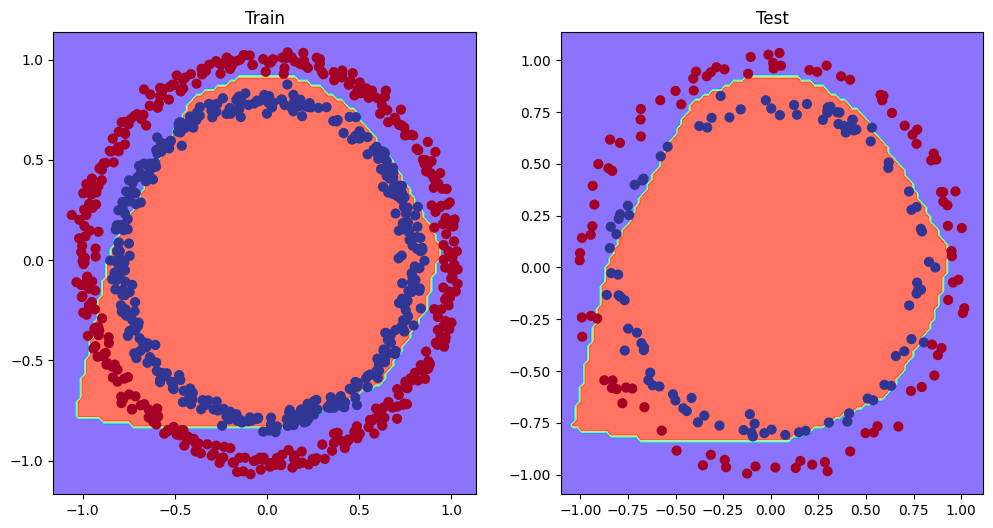

In [28]:
plt.figure(figsize=(12,6))
# 1 row in the plot, 2 columns in the plot, anything below in this slot 1
plt.subplot(1,2,1) 
plt.title("Train")
plot_decision_boundary(classifier, X_train, y_train)
# 1 row in the plot, 2 columns in the plot, anything below in this slot 2
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(classifier, X_test, y_test)

As seen above, the accuracy went higher after training with a small learning rate but a large number of epochs. However, it can be seen that by the time the training ended, the model was still training and would have performed better. So how do we get the best of both the worlds, i.e., train with a small enough learning rate such that the gradients do not jump with larger strides than required on the optimization function contour while also training faster with less number of epochs.

In order to get the best of both ways of training, we can use a **learning rate scheduler** that uses a large learning rate at first but gradually reduces it over time so that we can train the NN even with a small number of epochs. However, setting a small lr might also cause the gradient updates to be very small such that the training would never reach the optimization function minimum in a feasible amount of time. A better approach would be to use a large LR in the beginning but then reduce this LR gradually such that the training can result at a better accuracy within a feasible amount of time. On top of that, several new methods of learning rate scheduling have been introduced in the last decade. Here, we will use a single cyclic learning rate scheduler here.

#### Setting 3: Use a large LR with a **learning rate scheduler** with a medium number of epochs.

In [29]:
from torch.optim.lr_scheduler import CyclicLR

# use manual seed to ensure that we start with the same weights and biases as the model in setting 1.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

classifier = Custom_Classifier().to(device=device)
classifier


Custom_Classifier(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Using SGD/Adam optimizer
optimizer = torch.optim.SGD(params=classifier.parameters(), lr = 0.01)
# optimizer = torch.optim.Adam(params=classifier.parameters(), lr = 0.0001)
epochs = 50000

In [31]:

scheduler = CyclicLR(optimizer, 
                     base_lr = 0.0001, # Initial learning rate which is the lower boundary in the cycle for each parameter group
                     max_lr = 1e-3, # Upper learning rate boundaries in the cycle for each parameter group
                     step_size_up = 4, # Number of training iterations in the increasing half of a cycle
                     mode = "triangular")

In [32]:
#### Model Training

# ensure that you move the data to device in the same cell as the training loop
# this allows for model re-trianing without device error
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=42)

X_train = X_train.to(device = device)
y_train = torch.unsqueeze(y_train, dim=1) # convert to same dimension as the network output
y_train = y_train.to(device=device)
X_test = X_test.to(device = device)
y_test = y_test.to(device=device)
y_test = torch.unsqueeze(y_test, dim = 1) # convert to same dimension as the network output

# notice the increase in the number of epochs since the lr is very small
epoch_ctr = []
training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

for epoch in range(0, epochs):

    
    ### training mode
    classifier.train()

    # raw probabilities of each class
    train_prediction_logits = classifier(X_train)#.squeeze()
    train_prediction_probs = torch.sigmoid(train_prediction_logits)
    # rounded to 0 or 1
    train_predictions = torch.round(train_prediction_probs)

    
    
    # uncomment for prototyping
    assert train_prediction_logits.shape == y_train.shape
    training_loss = loss_func(train_prediction_logits, y_train) # note: prediction is in logit, y_train not in logit
    # calculate accuracy without tracking gradients
    with torch.inference_mode():
        training_acc= (torch.eq(torch.squeeze(train_predictions), torch.squeeze(y_train)).sum().item()/len(y_train)) * 100.
    
    optimizer.zero_grad()

    # backpropagation: calculate the gradients using backpropagation for the entire dataset at once
    # hence, this is not Stochastic Gradient Descent, but rather Gradient Descent
    training_loss.backward()

    optimizer.step()

    ### evaluation mode
    classifier.eval()
    
    # pass X through model during eval time in inference mode to disable gradient tracking
    with torch.inference_mode():        

        test_prediction_logits = classifier(X_test)#.squeeze()
        test_prediction_probs = torch.sigmoid(test_prediction_logits)
        test_predictions = torch.round(test_prediction_probs)
        
        # uncomment for prototyping
        assert test_prediction_logits.shape == y_test.shape
        test_loss = loss_func(test_prediction_logits, y_test)
        test_acc = (torch.eq(torch.squeeze(test_predictions), torch.squeeze(y_test)).sum().item()/len(y_test)) * 100.

        # store the epoch counter, lr, training less, and test loss for the plot
        epoch_ctr.append(epoch)
        
        training_loss_list.append(training_loss.to("cpu").item())
        test_loss_list.append(test_loss.to("cpu").item())
        training_acc_list.append(training_acc)
        test_acc_list.append(test_acc)

    if epoch % (epochs/10) == 0:
        print("\nEPOCH ", epoch, " | Training loss: ",round(training_loss.detach().item(),3)," | Test loss: ", round(test_loss.item(),3),\
        " | Training acc: ",round(training_acc,3),"% | Test acc: ", round(test_acc,3), "%")
    
    # update the learning rate
    scheduler.step()


EPOCH  0  | Training loss:  0.693  | Test loss:  0.693  | Training acc:  50.0 % | Test acc:  50.0 %

EPOCH  5000  | Training loss:  0.69  | Test loss:  0.69  | Training acc:  52.75 % | Test acc:  55.0 %

EPOCH  10000  | Training loss:  0.686  | Test loss:  0.686  | Training acc:  52.75 % | Test acc:  56.5 %

EPOCH  15000  | Training loss:  0.679  | Test loss:  0.677  | Training acc:  53.375 % | Test acc:  56.0 %

EPOCH  20000  | Training loss:  0.664  | Test loss:  0.66  | Training acc:  59.125 % | Test acc:  60.0 %

EPOCH  25000  | Training loss:  0.622  | Test loss:  0.62  | Training acc:  74.875 % | Test acc:  79.0 %

EPOCH  30000  | Training loss:  0.495  | Test loss:  0.512  | Training acc:  93.375 % | Test acc:  89.5 %

EPOCH  35000  | Training loss:  0.291  | Test loss:  0.339  | Training acc:  98.625 % | Test acc:  95.5 %

EPOCH  40000  | Training loss:  0.145  | Test loss:  0.192  | Training acc:  99.625 % | Test acc:  98.5 %

EPOCH  45000  | Training loss:  0.085  | Test los

Visualize loss and accuracy.

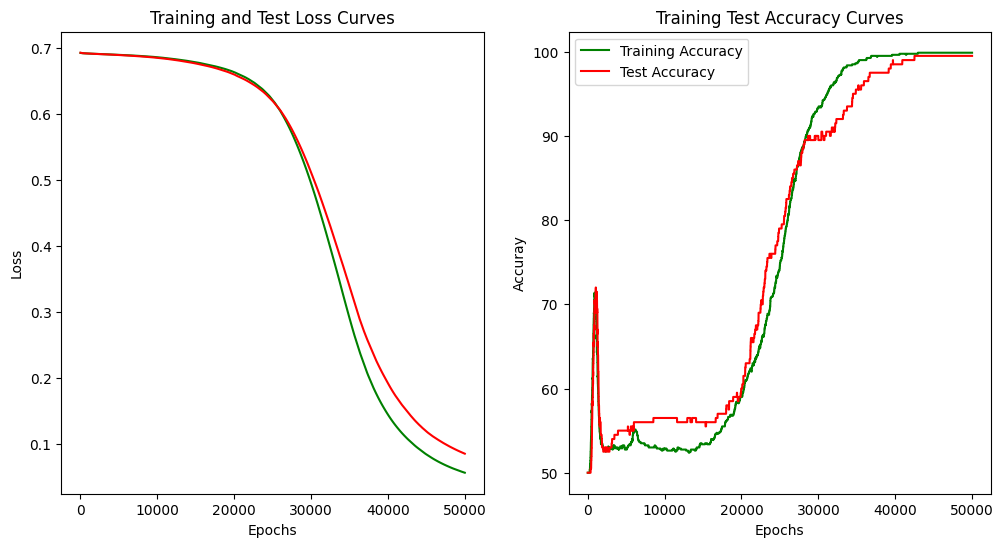

In [33]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epoch_ctr, training_loss_list, "g", label = "Training Loss")
plt.plot(epoch_ctr, test_loss_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epoch_ctr, training_acc_list, "g", label = "Training Accuracy")
plt.plot(epoch_ctr, test_acc_list, "r", label = "Test Accuracy")
plt.title("Training Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.savefig("images\\training_and_testing_performance.png")
plt.show()

Visualize the predictions.

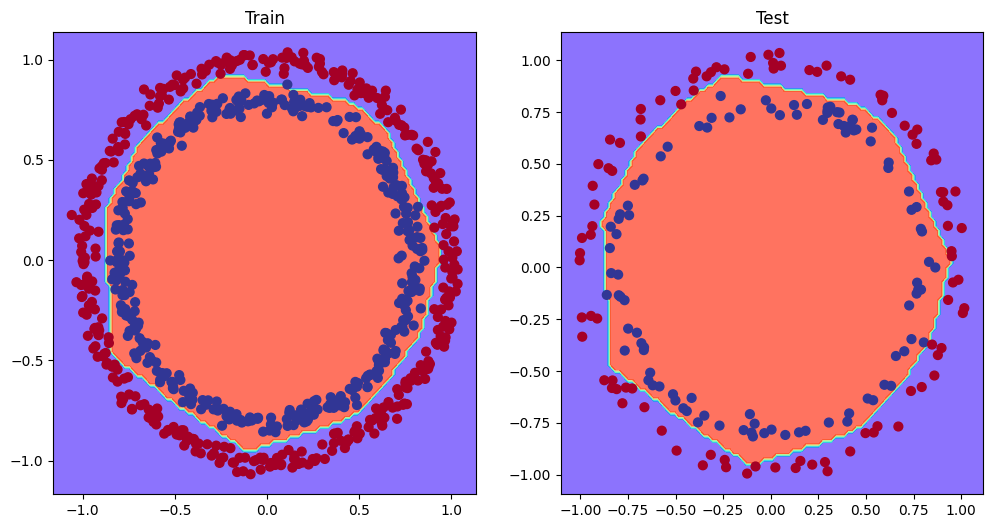

In [34]:
plt.figure(figsize=(12,6))
# 1 row in the plot, 2 columns in the plot, anything below in this slot 1
plt.subplot(1,2,1) 
plt.title("Train")
plot_decision_boundary(classifier, X_train, y_train)
# 1 row in the plot, 2 columns in the plot, anything below in this slot 2
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(classifier, X_test, y_test)
plt.savefig("images\\non_linear_classification_bounday.png")

Voila! As seen above the learning rate scheduler was able to update the learning rate overtime to give a 99.5% accuracy on the test predictions by the time the training was completed and the test accuracy has flattened by the end of the training which is what we desired from our training.